<h1>Weather Data Forecasting with Random Forest Regression</h1>

<h4>This project will use the Random Forest Regression model to forecast daily maximum temperature of 4 cities in the UK.<br><br>
This datasets used in this project was provided by metoffice. The cities include:</h4>
<ul><br>
    <li><h5>Oxford</h5></li>
    <li><h5>Cardiff</h5></li>
    <li><h5>Lerwick</h5></li>
    <li><h5>Camborne</h5></li>
</ul><br>
<h4>This project assumes that the first row of the txt files are the header</h4>

In [96]:
dfile_oxf = "data/metoffice_oxford_clean.txt"
dfile_car = "data/metoffice_cardiff_clean.txt"
dfile_ler = "data/metoffice_lerwick_clean.txt"
dfile_cam = "data/metoffice_camborne_clean.txt"

<h4>Only run this cell block if the modules are not installed yet</h4>

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

<h4>Then we can import all the modules</h4>

In [97]:
# Data Analysis Modules
import requests # Requests module for API calls
import re # Regex Module for string formatting
import pandas as pd # Pandas module for data management
import numpy as np # Numpy module for numerical analysis
import matplotlib.pyplot as plt # Matplotlib module for data visualisation

# Machine Learning Modules
from sklearn import tree # Decision Tree Module
from sklearn.model_selection import train_test_split # Built-in function for splitting training and testing dataset
from sklearn.ensemble import RandomForestRegressor # Random Forest Regression module (Ensemble Learning)
from sklearn.model_selection import GridSearchCV # Grid Search module for optimisation 
from sklearn.metrics import mean_squared_error # Mean Suared Error module for model evaluation

<h4>Meta Data of the datasets:</h4>

In [98]:
meta_data = pd.DataFrame(
    {"meta_data": ["primary key (unique id)", "year", "month", "mean daily maximum temperature", "mean daily minimum temperature",
    "days of air frost", "total rainfall", "total sunlight duration"]}, 
    index=["index", "yyyy", "mm", "tmax", "tmin", "af", "rain", "sun"]
)
meta_data

,meta_data
index,primary key (unique id)
yyyy,year
mm,month
tmax,mean daily maximum temperature
tmin,mean daily minimum temperature
af,days of air frost
rain,total rainfall
sun,total sunlight duration


In [99]:
# Specify some initial information
columns = ["yyyy", "mm", "tmax", "tmin", "af", "rain", "sun"]
delim = '\s+'
na_val = '---'

<h4>Exploratory Data Analysis</h4>

In [100]:
# Loading in the datasets
df_car = pd.read_csv(dfile_car, sep=delim, names=columns, na_values=na_val)
df_cam = pd.read_csv(dfile_cam, sep=delim, names=columns, na_values=na_val)
df_ler = pd.read_csv(dfile_ler, sep=delim, names=columns, na_values=na_val)
df_oxf = pd.read_csv(dfile_oxf, sep=delim, names=columns, na_values=na_val)

print(f"Cardiff has {df_car.shape[0]} rows and {df_car.shape[1]} columns")
print(f"Camborne has {df_car.shape[0]} rows and {df_car.shape[1]} columns")
print(f"Lerwick has {df_car.shape[0]} rows and {df_car.shape[1]} columns")
print(f"Oxford has {df_car.shape[0]} rows and {df_car.shape[1]} columns")

Cardiff has 521 rows and 7 columns
Camborne has 521 rows and 7 columns
Lerwick has 521 rows and 7 columns
Oxford has 521 rows and 7 columns


<h4>Since all datasets have the same shape. We can merge them into one big dataset</h4>

In [101]:
# Merging them into one big dataset
big_df = pd.concat([df_car, df_cam, df_ler, df_oxf])
big_df.describe()

,yyyy,mm,tmax,tmin,af,rain,sun
count,4129,4129,4129,4128,4128,4129,2913
unique,169,13,248,193,30,1565,1659
top,2010,12,9.6,3.5,0,43.1,79.3
freq,48,346,46,51,2185,11,6


In [102]:
print(f"number of null values:\n{big_df.isna().sum()}\n")
print(f"total: {big_df.isna().sum().sum()}")

number of null values:
yyyy       0
mm         0
tmax       0
tmin       1
af         1
rain       0
sun     1216
dtype: int64

total: 1218


<p>Since most of the null values are in the sunlight column. And only 2 null values are in min temperature, and air frost respectively, we can just discard them. To deal with the missing sunlight values we will use numpy's random number generation to simulate values based on historic mean and standard deviation.<br><br>
We also assume that the distribution of sunlight follows a normal distribution.</p>

In [103]:
def simulate_values(mean, std, length):
    # Generate a True Random integer from 0 to 100 from random.org
    url = f'https://www.random.org/integers/?num=1&min=0&max=100&col=5&base=10&format=plain'
    seed = int(requests.get(url).text)
    
    np.random.seed(seed) # Sets numpy's pseudo-random generator with the random number
    results = np.random.normal(mean, std, length) # Simulates values
    return results

<h4>Data Cleaning & Pre-Processing</h4>

In [104]:
# Defines a function that cleans the dataset (make it look nicer)
def clean(ds):
    # Gets rid of the first row (duplicate header)
    ds.drop(0, axis=0, inplace=True)
    ds.reset_index(inplace=True)
        
    # Reformats the code, changes all symbols to whitespace
    # Then transform them into floats
    cleaned_ds = ds.replace('[^\d.]', '', regex=True)
    ds = cleaned_ds.astype('float')
    
    # Finds the mean and standard deviation of the sunlight values
    avg_sun = ds["sun"].mean()
    std_sun = ds["sun"].std()

    # Finds the amount of missing values
    sum_sun = ds["sun"].isna().sum()

    # Replaces the missing values with the simulated values
    simulated = simulate_values(avg_sun, std_sun, sum_sun)
    ds.loc[ds["sun"].isna(), "sun"] = simulated

    # Drops the remaining column
    ds.dropna()
    return ds

In [105]:
# Cleaning the dataset
big_df = clean(big_df)

<h2>Random Forest Regression Model</h2>
<p>Random forest regression is an ensemble learning model. Ensemble means "together" in French. This tells us that ensemble learning models consist of multiple machine learning models working towards the same goal. Random forest regression involves creating multiple decision trees using bootstrap aggregating. Each tree is trained on a different subset of the data. Predictions are then made by averaging the predictions of all the trees.</p>

<h4>But what are Decision Trees?</h4>
Decision trees are a machine learning technique that organizes data into a tree-like structure. Each internal node represents a feature, each branch represents a decision based on that feature, and each leaf node represents a predicted outcome.

<h5>This may take a while (1-2 mins) so grab a drink :)</h5>

In [106]:
# Splits the parameters and the target variable
x_vals = big_df[["tmin", "af", "rain", "sun"]]
y_val = big_df["tmax"]

# Use the common 80/20 training and testing data split
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_val, test_size=0.2, random_state=0)

# Set of estimators we want to optimise
param_grid = {'n_estimators': [50, 100, 150, 200, 250]}

# Create the Random Forest regressor
rf = RandomForestRegressor()

# Perform grid search with cross-validation
# We use the 10-fold cross validation because we have a smaller dataset
# We also use the mean squared error for the evaluation metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_n_estimators = grid_search.best_params_['n_estimators']
print("Best number of estimators:", best_n_estimators)

# Refit the model with the best parameters
# We want scikit-learn to randomly shuffle our data for unbiasedness, so we make the random state None
best_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=None)
best_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_model.predict(X_test)

Best number of estimators: 250


<h3>Visualisation of the first 3 trees in the random forest (from a dummy model)</h3>

Text(0.5, 0.98, 'Visualisation of Decision Trees with 3 levels deep')

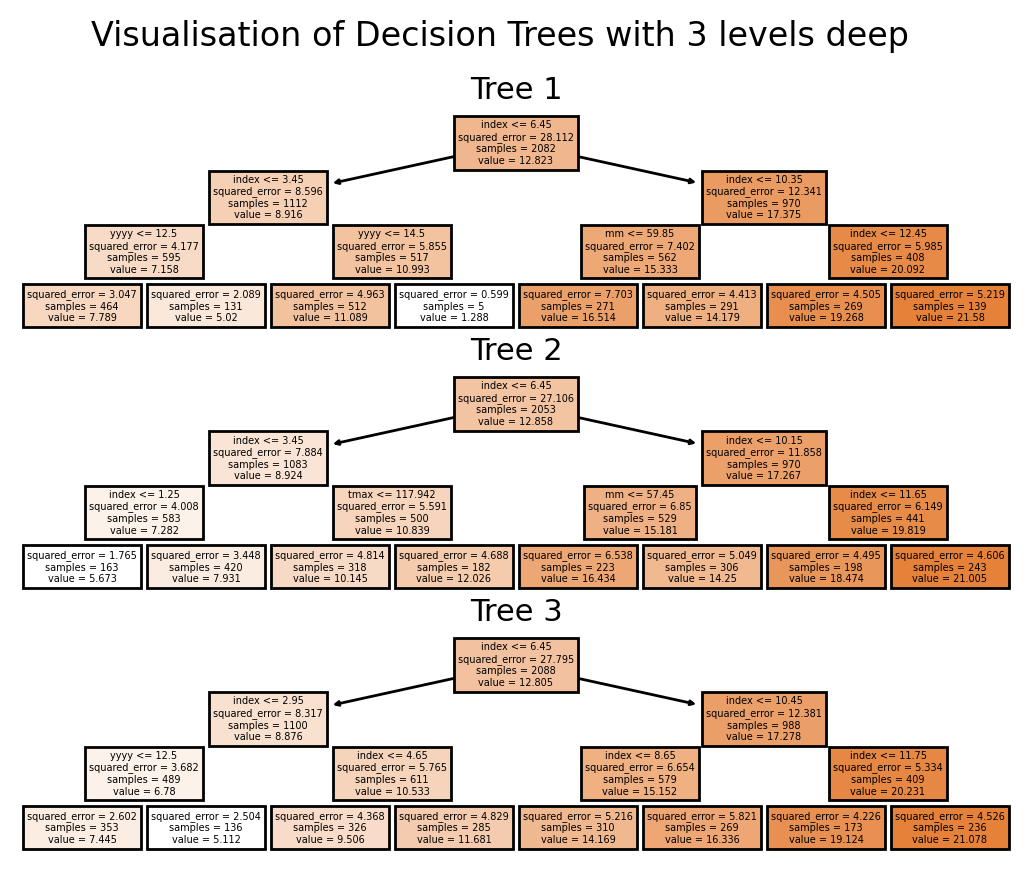

In [107]:
# Visualising the tree
# Dummy random forest model on the same data
depth = 3
trees = 3

dummy_model = RandomForestRegressor(n_estimators=trees, random_state=None, max_depth=depth)
dummy_model.fit(X_train, y_train)

features = big_df.columns

fig, axes = plt.subplots(nrows = trees, ncols = 1, dpi = 200)
for index in range(0, trees):
    tree.plot_tree(dummy_model.estimators_[index], filled=True, ax = axes[index], feature_names=features, class_names=True)
    axes[index].set_title('Tree ' + str(index + 1), fontsize = 11)
    
fig.suptitle(f"Visualisation of Decision Trees with {depth} levels deep")

<h4>Model Evaluation</h4>

Mean Squared Error: 3.0381050734545463


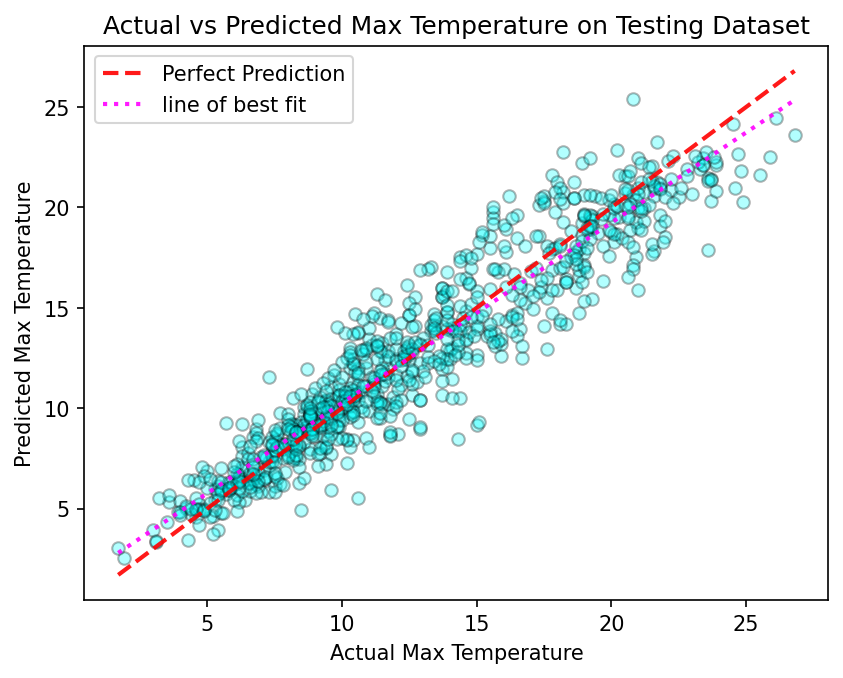

In [108]:
coefficients = np.polyfit(y_test, y_pred, 1)
poly_function = np.poly1d(coefficients)

# Generate the polynomial curve
x_values = np.linspace(min(y_test), max(y_test), 100)
y_values = poly_function(x_values)

# Plot actual vs predicted temperatures
fig, axes = plt.subplots(dpi = 150)
axes.scatter(y_test, y_pred, color='cyan', edgecolor='black', alpha=0.3)
axes.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], alpha=0.9, color='red', linewidth=2, linestyle='--', label='Perfect Prediction')
axes.plot(x_values, y_values, label='line of best fit', alpha=0.9, color='magenta', linewidth=2, linestyle=':')

axes.set_xlabel('Actual Max Temperature')
axes.set_ylabel('Predicted Max Temperature')
axes.set_title('Actual vs Predicted Max Temperature on Testing Dataset')

axes.legend()

print(f"Mean Squared Error: {mean_squared_error(y_pred, y_test)}")

<p>From the plot above we can see that the model did a decent job in predicting mean daily maximum temperature of the four cities. The red line is the perfect prediction line (where the mean squared error is 0) and the magenta line is the line of best fit for the predictions.</p>